# __Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers__

#### <u>Importation des modules nécessaires</u>

In [1]:
import os
import umap
import h5py
import sklearn
import datetime 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import torch
from torch import nn
import torch.nn.functional as F

# Custom
import common.plotting
import common.dataprocessing

## __Première partie : Annexe__

### **Étape 0 : Initialisation des fonctions de visulisation des données**

In [2]:
def plot_multiple_learning_curves(nb_exp, colors, info_exp, title, err_precis) : 

    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    steps = np.arange(len(err_precis[0][0]))

    for exp in range(nb_exp) : 
        axes[0].plot(steps, err_precis[exp][0], label = f"Entraînement ({info_exp[exp]})", color = colors[exp][0])
        axes[0].plot(steps, err_precis[exp][1], label= f"Test ({info_exp[exp]})", color = colors[exp][1])
        axes[1].plot(steps, err_precis[exp][2], label = "", color = colors[exp][0])
        axes[1].plot(steps, err_precis[exp][3], label = "", color = colors[exp][1])
    
    axes[0].set_ylabel("Erreur quadratique moyenne (MSE)")
    axes[1].set_ylabel("Précision (%)")
    axes[1].set_ylim((0,105))

    axes[1].set_xlabel("Pas de gradient (époques)")
    axes[0].legend()

    axes[0].set_title('A', loc="left", weight="bold")
    axes[1].set_title('B', loc="left", weight="bold")   

    axes[0].set_title(title)

In [3]:
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc, label = "train")
    axes[1].plot(steps, tstc, label= "test")
    axes[0].set_ylabel("MSELoss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on ML data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")

def plot_ae_performance(mm, X_test):
    y_tst_out = mm(X_test)
    outs = y_tst_out.flatten().detach().numpy()
    trues = X_test.flatten().detach().numpy()
    corr =  pearsonr(outs,trues).statistic
    plt.figure(figsize = (9,7))
    plt.grid(visible =True, alpha = 0.5, linestyle = "--")
    plt.plot([0,1],[0,1], color = "blue", alpha =0.5, linestyle = "--")
    plt.hexbin(outs, trues, bins = "log")
    plt.xlabel("Predicted Expressions (normalised TPM)")
    plt.ylabel("True expressions")
    plt.colorbar(label='log10(N)')
    plt.axis("equal")
    plt.title(f"Auto-Encoder performance of reconstruction on test set.\nPearson Correlation: {round(corr,4)}")

In [4]:
# Fonction d'affichage de UMAP 
# Paramètres:
# Targets: Liste des labels présent dans le jeu de données
# Colors: Vecteur avec une liste de couleurs (doit correspondre au nombre de targets)
# X_tr_Umap et X_tst_umap: Dataframe des résultats de Umap
# Y_train, Y_test : Labels des ensembles test et train
def plotUMAP(targets, colors, X_tr_umap_df, X_tst_umap_df, Y_test, Y_train):
    plt.figure()
    for target, color in zip(targets, colors): 
        plt.scatter(X_tr_umap_df.loc[Y_train == target,0], X_tr_umap_df.loc[Y_train == target, 1], 
                    color = color, s = 10, label = target)
        plt.scatter(X_tst_umap_df.loc[Y_test == target,0], X_tst_umap_df.loc[Y_test == target, 1], 
                    s = 10, edgecolors = color, color ="white", linewidth = 0.8)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")

    # Légende personnaliée
    legend_elements = [Line2D([0], [0], marker = "o", markerfacecolor = "black", 
                            label = "Train", color = "w", markeredgewidth = 0.8,
                             markeredgecolor= "black", markersize=4), 
                    Line2D([0], [0], marker = "o", markerfacecolor = "w", 
                            markeredgewidth= 0.5, markeredgecolor= "black",
                            label = "Test", color = "w", markersize=4)]
    legend_supp = plt.legend(handles=legend_elements, loc = "lower left",
                        frameon = False,
                        title = "Ensemble")
    #bbox_to_anchor=(1.25, 0.55)
    plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1.02), frameon = False,
           title = "Type de cancer")
    plt.gca().add_artist(legend_supp)

### **Étape I : Importation et visualisation des données avec UMAP**

#### <u>Importation des jeux de données</u>

In [6]:
datasets = common.dataprocessing.load_datasets()

##### <u>Visualisation de BRCA avec UMAP</u>

In [7]:
# Extraires les différentes variables du jeux de données
datasetname = "BRCA"
brca_data = datasets[datasetname].data
genes_br = datasets[datasetname].genes
labels_br = datasets[datasetname].labels
samples_br = datasets[datasetname].samples

targets_br = np.unique(labels_br)
labels_df_br = pd.DataFrame(labels_br)

print(f"Nbre d'échantillons: {len(samples_br)} -- Nbre de gènes: {len (genes_br)} -- Nbre d'étiquettes: {len(targets_br)}")

Nbre d'échantillons: 1023 -- Nbre de gènes: 11802 -- Nbre d'étiquettes: 5


In [35]:
# Séparation des données d'entraînement et de test
X_train_br, X_test_br, Y_train_br, Y_test_br = train_test_split(brca_data.T, labels_br, test_size = 0.2)

In [37]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_br) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_br)
X_tst_umap = mapper.transform(X_test_br)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sun Dec 10 16:54:10 2023 Construct fuzzy simplicial set
Sun Dec 10 16:54:11 2023 Finding Nearest Neighbors
Sun Dec 10 16:54:11 2023 Finished Nearest Neighbor Search
Sun Dec 10 16:54:11 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 10 16:54:15 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


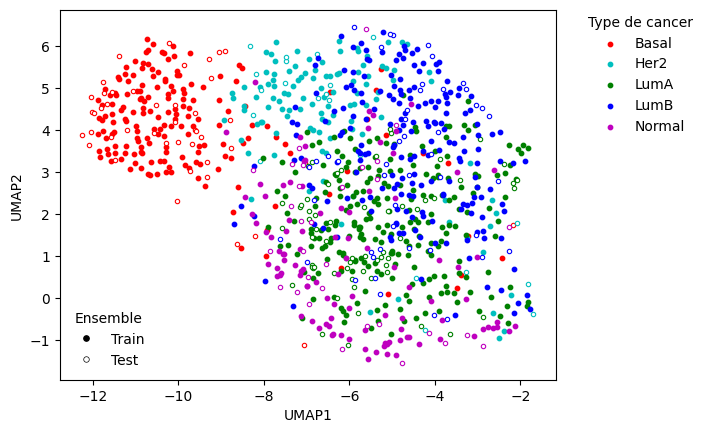

In [42]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_br = ["r", "c", "g", "b", "m"]
plotUMAP(targets_br, colors_br, X_tr_umap_df, X_tst_umap_df, Y_test_br, Y_train_br)

##### <u>Visualisation de TCGA avec UMAP</u>

In [5]:
# Extraires les différentes variables du jeux de données
datasetname = "TCGA"
tcga_data = datasets[datasetname].data
genes_tc = datasets[datasetname].genes
labels_tc = datasets[datasetname].labels
samples_tc = datasets[datasetname].samples

targets_tc = np.unique(labels_tc)
labels_df_tc = pd.DataFrame(labels_tc)

print(f"Nbre d'échantillons: {len(samples_tc)} -- Nbre de gènes: {len (genes_tc)} -- Nbre d'étiquettes: {len(targets_tc)}")

NameError: name 'datasets' is not defined

In [44]:
# Séparation des données d'entraînement et de test
X_train_tc, X_test_tc, Y_train_tc, Y_test_tc = train_test_split(tcga_data.T, labels_tc, test_size = 0.2)

# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_tc) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_tc)
X_tst_umap = mapper.transform(X_test_tc)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sun Dec 10 16:56:12 2023 Construct fuzzy simplicial set
Sun Dec 10 16:56:12 2023 Finding Nearest Neighbors
Sun Dec 10 16:56:12 2023 Building RP forest with 10 trees
Sun Dec 10 16:56:13 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sun Dec 10 16:56:16 2023 Finished Nearest Neighbor Search
Sun Dec 10 16:56:17 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 10 16:56:39 2023 Finished embedding
Sun Dec 10 16:56:41 2023 Worst tree score: 0.80799903
Sun Dec 10 16:56:41 2023 Mean tree score: 0.82693330
Sun Dec 10 16:56:41 2023 Best tree score: 0.83458192
Sun Dec 10 16:56:41 2023 Forward diversification reduced edges from 165520 to 43111
Sun Dec 10 16:56:41 2023 Reverse diversification reduced edges from 43111 to 43111
Sun Dec 10 16:56:41 2023 Degree pruning reduced edges from 46642 to 46642
Sun Dec 10 16:56:41 2023 Resorting data and graph based on tree order
Sun Dec 10 16:56:42 2023 Building and compiling search function


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


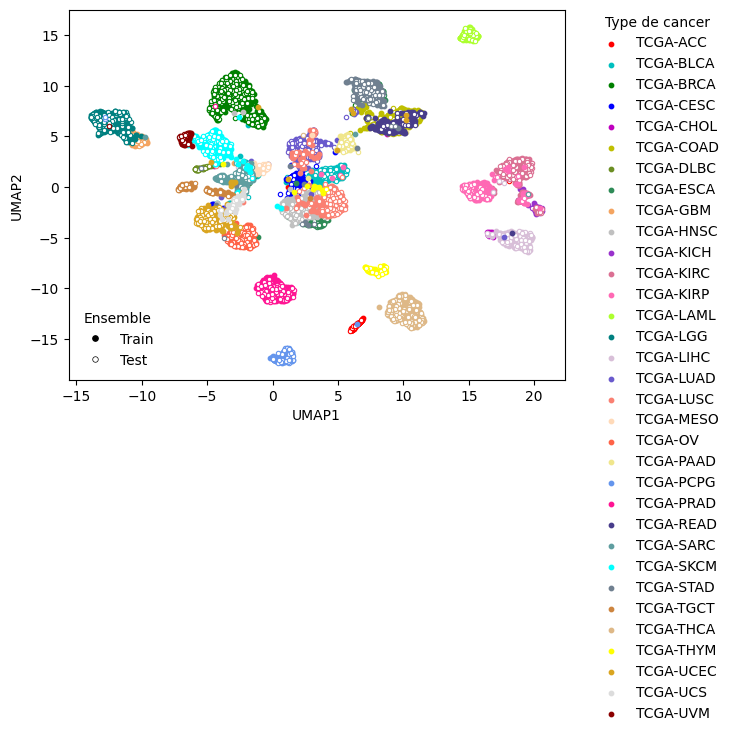

In [45]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_tc = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver", "darkorchid", "palevioletred",
          "hotpink", "greenyellow", "teal", "thistle", "slateblue",
          "salmon", "peachpuff", "tomato", "khaki", "cornflowerblue",
          "deeppink", "darkslateblue", "cadetblue", "aqua", "slategrey",
          "peru", "burlywood", "yellow", "goldenrod", "gainsboro", "darkred"]

plotUMAP(targets_tc, colors_tc, X_tr_umap_df, X_tst_umap_df, Y_test_tc, Y_train_tc)

##### <u>Visualisation de Leucogène - AML avec UMAP</u>

In [46]:
# Extraires les différentes variables du jeux de données
datasetname = "LAML"
laml_data = datasets[datasetname].data
genes_la = datasets[datasetname].genes
labels_la = datasets[datasetname].labels
samples_la = datasets[datasetname].samples

targets_la = np.unique(labels_la)
labels_df_la = pd.DataFrame(labels_la)

print(f"Nbre d'échantillons: {len(samples_la)} -- Nbre de gènes: {len (genes_la)} -- Nbre d'étiquettes: {len(targets_la)}")

Nbre d'échantillons: 300 -- Nbre de gènes: 19597 -- Nbre d'étiquettes: 15


In [47]:
# Séparation des données d'entraînement et de test
X_train_la, X_test_la, Y_train_la, Y_test_la = train_test_split(laml_data.T, labels_la, test_size = 0.2)

# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_la) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_la)
X_tst_umap = mapper.transform(X_test_la)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sun Dec 10 17:01:50 2023 Construct fuzzy simplicial set
Sun Dec 10 17:01:50 2023 Finding Nearest Neighbors
Sun Dec 10 17:01:50 2023 Finished Nearest Neighbor Search
Sun Dec 10 17:01:50 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 10 17:01:52 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


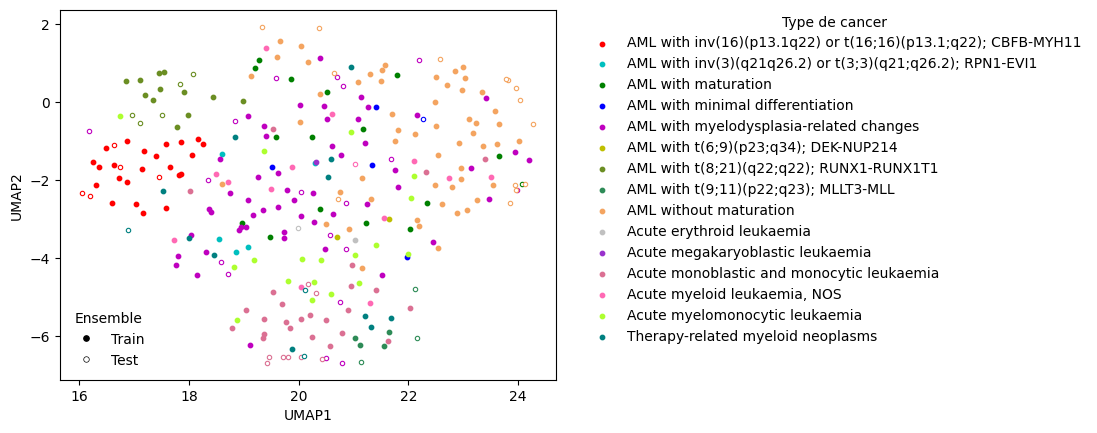

In [48]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_la = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver", "darkorchid", "palevioletred",
          "hotpink", "greenyellow", "teal"]

plotUMAP(targets_la, colors_la, X_tr_umap_df, X_tst_umap_df, Y_test_la, Y_train_la)

##### <u>Visualisation des données TALL avec UMAP</u>

In [52]:
# Extraires les différentes variables du jeux de données
datasetname = "TALL"
tall_data = datasets[datasetname].data
genes_ta = datasets[datasetname].genes
labels_ta = datasets[datasetname].labels
samples_ta = datasets[datasetname].samples

targets_ta = np.unique(labels_ta)
labels_df_ta = pd.DataFrame(labels_ta)

print(f"Nbre d'échantillons: {len(samples_ta)} -- Nbre de gènes: {len (genes_ta)} -- Nbre d'étiquettes: {len(targets_ta)}")

Nbre d'échantillons: 264 -- Nbre de gènes: 60660 -- Nbre d'étiquettes: 10


In [53]:
# Séparation des données d'entraînement et de test
X_train_ta, X_test_ta, Y_train_ta, Y_test_ta = train_test_split(tall_data.T, labels_ta, test_size = 0.2)

# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_ta) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_ta)
X_tst_umap = mapper.transform(X_test_ta)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sun Dec 10 17:08:59 2023 Construct fuzzy simplicial set
Sun Dec 10 17:09:00 2023 Finding Nearest Neighbors
Sun Dec 10 17:09:00 2023 Finished Nearest Neighbor Search
Sun Dec 10 17:09:00 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 10 17:09:03 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


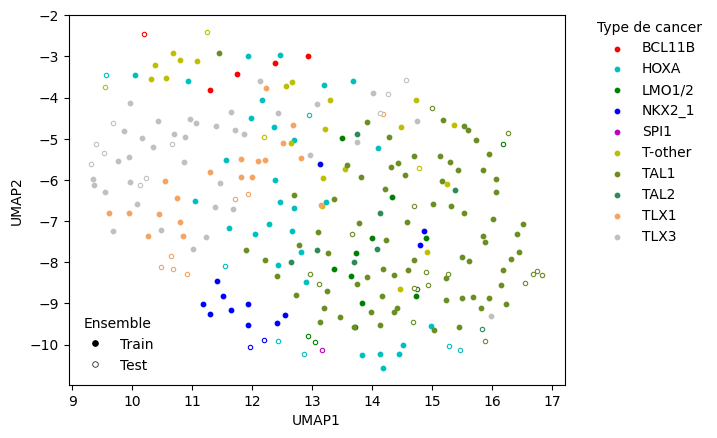

In [54]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_ta = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver"]

plotUMAP(targets_ta, colors_ta, X_tr_umap_df, X_tst_umap_df, Y_test_ta, Y_train_ta)

### **Étape II : Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur sur les données de BRCA**

#### <u>Introduction</u>

L'autoencodeur (1) est un réseau qui consiste à faire, entre autres, de la réduction de dimensionnalité avec un réseau de neurones. Cette réduction force le réseau à capter les corrélations essentielles entre les données pour les reproduire le plus fidèlement possible en sortie. Cela permet aussi de créer des modèles génératifs, c'est à dire des modèles qui peuvent générer des données qui auront les mêmes propriétés que les données d'entraînement. Le modèle a été pour la première fois abordé par Kramer en 1991 (2), mais il n'a été popularisé pour la réduction de dimensionnalité qu'en 2006 avec Hinton (3).

Références: 

(1): https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/ # Est-ce que c'est ça qu'ils veulent pour la doc ??

(2): https://people.engr.tamu.edu/rgutier/web_courses/cpsc636_s10/kramer1991nonlinearPCA.pdf

(3): https://www.science.org/doi/10.1126/science.1127647 

**** Je crois que pour les références il veut que ce soit vraiment un format style Vancouver ou APA comme on fait d'habitude ****

#### <u>Binarisation des étiquettes</u>

In [21]:
lblbin = LabelBinarizer()
# Transformation + cast en Tensor
Y = torch.Tensor(lblbin.fit_transform(labels_br))

# Fabrication des échantillons d'entraînement et de test (cast en Tensor)
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

#### <u>Fonction d'initialisation de l'autoencodeur</u>


In [8]:
def buildModel(inSize, outSize, width, bnSize) :

    """
    Construit un autoencodeur avec 5 couches (toutes ReLU sauf pour la 
    couche centrale (espace latent)).

        Paramètres:
            inSize (int): taille des données d'entrée
            outSize (int): taille des données de sortie
            width (int): taille à travers le réseau (nombre de neurones entrant
                ou sortant d'une couche si non spécifié, couches internes)
            bnSize (int): taille de l'espace latent

        Retourne:
            model (Sequential): modèle au complet (autoencodeur)
            model[0:5] (Sequential): partie encodeur du modèle
    """

    model = nn.Sequential(
        nn.Linear(inSize, width),
        nn.ReLU(),
        nn.Linear(width, width),
        nn.ReLU(),
        nn.Linear(width, bnSize), # couche centrale
        nn.Linear(bnSize, width),
        nn.ReLU(),
        nn.Linear(width, outSize),
    )

    return model, model[0:5]


#### <u>Fonction d'entraînement de l'autoencodeur</u>

In [9]:
def trainModel(model, X_train, X_test, epochs, learningRate, weightDecay) : 

    """
    Entraîne un autoencodeur.

        Paramètres:
            model (Sequential): Modèle à entraîner
            X_train (Tensor): Données transcriptomiques d'entraînement
            X_test (Tensor): Données transcriptomiques de test
            epochs (int): Dombre d'époques d'entraînement
            adamPenalty (float): Pénalité utlisé dans l'algorithme
                d'optimisation Adam

        Retourne:
            trainLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble d'entraînement
            testLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble de test
            trainAccs (list): Corrélation de Pearson (0 à 1) entre réel et
                prédit de l'ensemble d'entraînement
            testAccs (list): Corrélation de Pearson (0 à 1) entre réel et 
                prédit de l'ensemble de test
    """

    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay = weightDecay)
    trainLosses, testLosses, trainAccs, testAccs = [], [], [], []

    for epoch in range(epochs) :

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = model(X_train)
        outTest = model(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        # Ajout aux listes
        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc)), testAccs.append(float(testAcc))]

        trainError.backward()
        optimizer.step()

        # Visualisation en temps réel de l'entraînement
        if epoch % 10 == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc), 2)} ~ Test Acc : {round(float(testAcc), 2)} ")

    return trainLosses, testLosses, trainAccs, testAccs



#### <u>Création de l'autoencodeur</u>

In [22]:
# Modèle d'autoencodeur
ae, en = buildModel(X_train.shape[1], X_train.shape[1], 100, 2)
# Entraînement du modèle
trainMSE, testMSE, trainCorr, testCorr = trainModel(ae, X_train, X_test, 200, 0.001, 0.001)

Epoch 0 --- Train Error : 0.17 ~ Test Error : 0.17 ~ Train Acc : 0.01 ~ Test Acc : 0.01 
Epoch 10 --- Train Error : 0.14 ~ Test Error : 0.14 ~ Train Acc : 0.09 ~ Test Acc : 0.09 
Epoch 20 --- Train Error : 0.11 ~ Test Error : 0.11 ~ Train Acc : 0.2 ~ Test Acc : 0.19 
Epoch 30 --- Train Error : 0.09 ~ Test Error : 0.09 ~ Train Acc : 0.28 ~ Test Acc : 0.28 
Epoch 40 --- Train Error : 0.05 ~ Test Error : 0.05 ~ Train Acc : 0.44 ~ Test Acc : 0.43 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.64 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.64 ~ Test Acc : 0.64 
Epoch 70 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 80 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 90 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 100 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 110 -

#### <u>Visualisation de la performance</u>

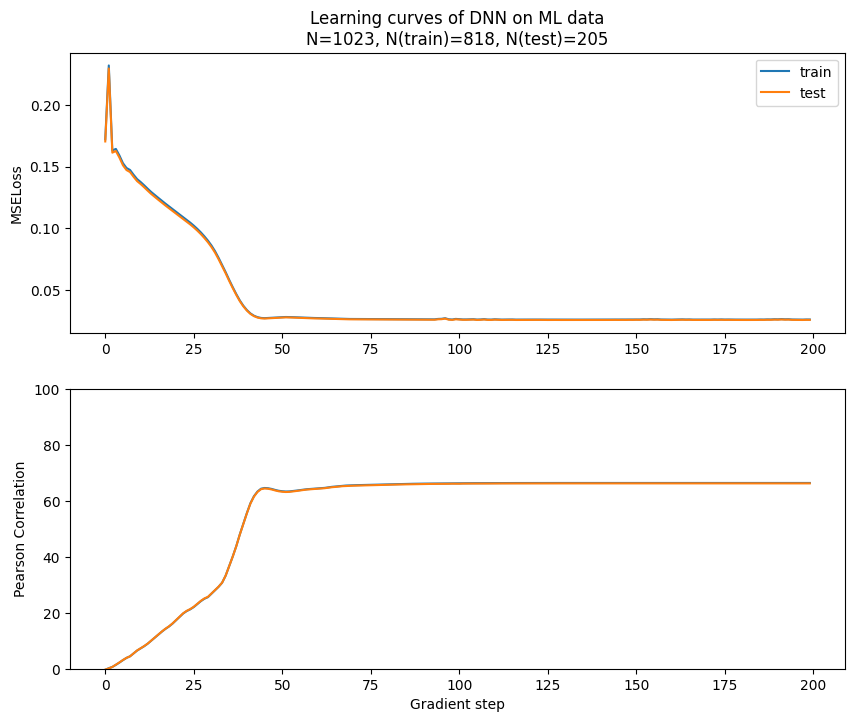

In [11]:
# Conversion de la précision en %
trainCorrPct = [corr * 100 for corr in trainCorr]
testCorrPct = [corr * 100 for corr in testCorr]

# Apprentissage
plot_learning_curves(trainMSE, testMSE, trainCorrPct, testCorrPct, brca_data, X_train, X_test)

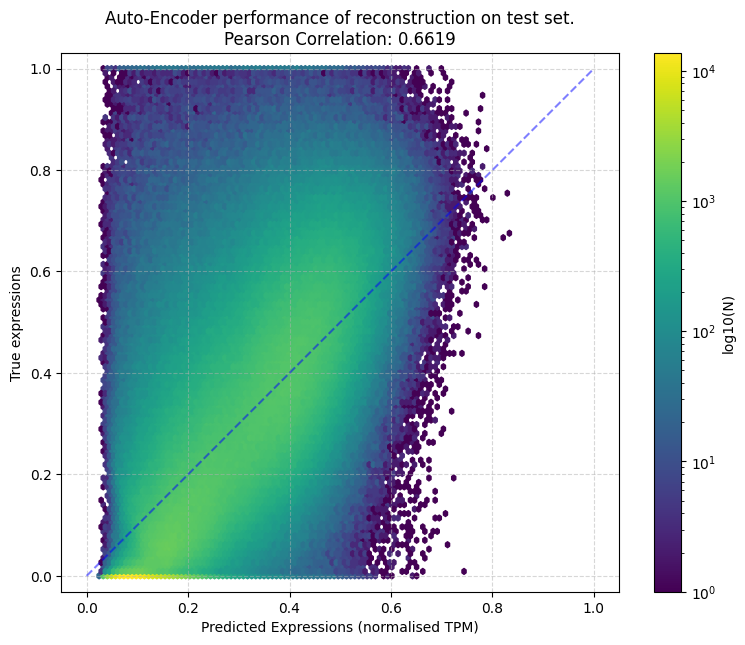

In [12]:
# Performance
plot_ae_performance(ae, X_test)

### **Étape III: Implémentation d'un Variational Auto-Encoder (VAE)**

##### <u>Introduction</u>

L'autoencodeur variationnel (1) est très semblable à l'auto-encodeur. Au lieu de devoir produire une copie exacte des données en sortie (comme l'auto-encodeur), le modèle doit fournir une distribution des données. Même s'il peut faire les mêmes choses qu'un autoencodeur traditionnel, il est surtout utilisé pour de la réduction de dimensionnalité sur des données bruitées. Ce modèle a été crée par Diederik P Kingma et Max Welling en 2013 (2).

Références: 

(1): https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f # Lien pour la doc ??

(2): https://arxiv.org/abs/1312.6114 

#### <u>Initialisation des classes et fonctions des auto-encodeurs variationnels</u>

In [10]:
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [11]:
def train_Variational_Autoencodeur (insize, bnsize, X_train, X_test, nepochs = 1000, printstep=100, wd = 1e-3, lr = 0.0001):
    DNN = VariationalAutoencoder(insize, bnsize)
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    trainLosses, testLosses, trainAccs, testAccs = [],[],[],[]
    
    for epoch in range(nepochs):

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = DNN(X_train)
        outTest = DNN(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        trainError.backward()
        optimizer.step()

        if epoch % printstep == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc*100), 2)} ~ Test Acc : {round(float(testAcc*100), 2)} ")

        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc*100)), testAccs.append(float(testAcc*100))]
    return trainLosses, testLosses, trainAccs, testAccs

#### <u>Utilisation des données initialisées précedemment</u>

#### <u>Création du modèle</u>

In [15]:
vae = VariationalAutoencoder(X_train.shape[1], 2)
vae(X_train)
tr_losses, tst_losses, tr_accs, tst_accs = train_Variational_Autoencodeur(X_train.shape[1], 2, X_train, X_test)

Epoch 0 --- Train Error : 0.22 ~ Test Error : 0.21 ~ Train Acc : 0.29 ~ Test Acc : 0.34 
Epoch 100 --- Train Error : 0.14 ~ Test Error : 0.14 ~ Train Acc : 7.41 ~ Test Acc : 7.44 
Epoch 200 --- Train Error : 0.12 ~ Test Error : 0.12 ~ Train Acc : 15.91 ~ Test Acc : 15.89 
Epoch 300 --- Train Error : 0.04 ~ Test Error : 0.04 ~ Train Acc : 49.86 ~ Test Acc : 49.74 
Epoch 400 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 65.93 ~ Test Acc : 65.79 
Epoch 500 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.24 ~ Test Acc : 66.09 
Epoch 600 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.3 ~ Test Acc : 66.14 
Epoch 700 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.32 ~ Test Acc : 66.16 
Epoch 800 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.34 ~ Test Acc : 66.18 
Epoch 900 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.39 ~ Test Acc : 66.22 


#### <u>Visualisation de l'apprentissage et de la performance</u>

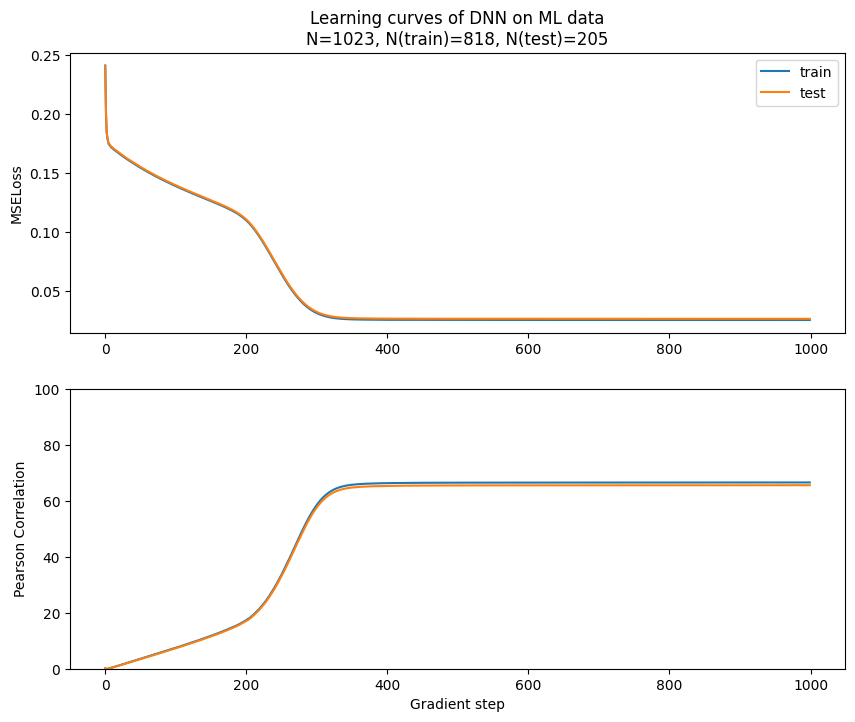

In [28]:
plot_learning_curves(tr_losses, tst_losses, tr_accs, tst_accs, brca_data, X_train, X_test)

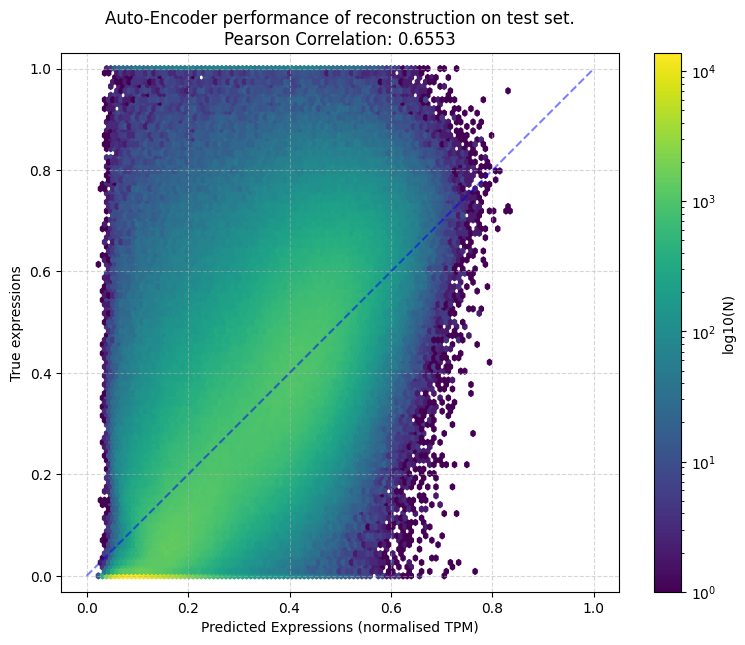

In [26]:
# Visualisation avec un diagramme de densité
common.plotting.plot_ae_performance(ae, X_test) # À modifier 

### **Étape IV : UMAP supervisé sur les données de BRCA**

##### <u>Introduction</u>

L'UMAP supervisé (1) est un entraînement de UMAP où les étiquettes de prédiction sont précisés. L'apprentissage supervisé permet de faciliter le processus de réduction de dimensionnalité de UMAP. En effet, cela permet au modèle d'associer une distance avec chaque classe, permettant ainsi de mieux séparer les données, améliorant ainsi la visualisation. Le modèle a été conçu par Leland McInnes, John Healy, et James Melville en 2020 (2).

Références: 

(1): https://umap-learn.readthedocs.io/en/latest/supervised.html#training-with-labels-and-embedding-unlabelled-test-data-metric-learning-with-umap 

(2): https://arxiv.org/abs/1802.03426 

In [18]:
lblenc = LabelEncoder()
lblenc.fit(labels_br)
Y = lblenc.transform(labels_br)
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Tue Dec 12 19:51:45 2023 Construct fuzzy simplicial set
Tue Dec 12 19:51:46 2023 Finding Nearest Neighbors
Tue Dec 12 19:51:46 2023 Finished Nearest Neighbor Search
Tue Dec 12 19:51:46 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Dec 12 19:51:49 2023 Finished embedding


In [12]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


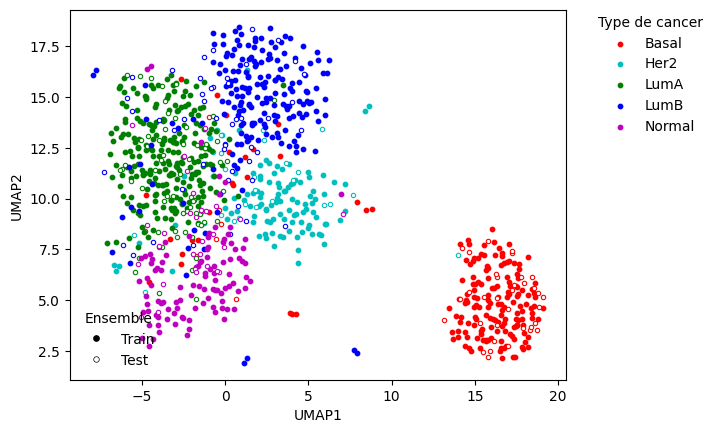

In [15]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_br = ["r", "c", "g", "b", "m"]
plotUMAP(targets_br, colors_br, X_tr_umap_df, X_tst_umap_df, lblenc.inverse_transform(Y_test), lblenc.inverse_transform(Y_train))

## **Deuxième partie : Projet**

### **Hyper-paramétrisation et comparaison des performances des auto-encodeurs et des VAE pour la régression sur de vraies données transcriptomiques des cancers**

#### A. <u>Fixation de la taille des couches internes, de la régularisation L2 (wd, weight decay) et du taux d'apprentissage (lr, learning rate).</u> 

<u>Auto-encodeur (AE)</u>

- Initialisation de l'AE avec **buildModel**
- Entraînement de l'AE avec **trainModel**

In [ ]:
# Génération des ensembles tests et train 
lblbin = LabelBinarizer()
# Transformation + cast en Tensor
Y = torch.Tensor(lblbin.fit_transform(labels_br))

# Fabrication des échantillons d'entraînement et de test (cast en Tensor)
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

In [23]:
# Variation dans la taille des couches internes
insize = X_train.shape[1]
outsize = X_train.shape[1]
tests_couche_interne = []

for i in range(1,5) :
    ae_ci, en_ci = buildModel(insize, outsize, i*100, 2)
    trainMSE_ci, testMSE_ci, trainCorr_ci, testCorr_ci = trainModel(ae_ci, X_train, X_test, 100, 0.001, 0.001)
    tests_couche_interne.append([trainMSE_ci, testMSE_ci, [i * 100 for i in trainCorr_ci], [i * 100 for i in trainCorr_ci]])

Epoch 0 --- Train Error : 0.18 ~ Test Error : 0.18 ~ Train Acc : -0.0 ~ Test Acc : -0.0 
Epoch 10 --- Train Error : 0.14 ~ Test Error : 0.14 ~ Train Acc : 0.08 ~ Test Acc : 0.08 
Epoch 20 --- Train Error : 0.11 ~ Test Error : 0.11 ~ Train Acc : 0.19 ~ Test Acc : 0.19 
Epoch 30 --- Train Error : 0.08 ~ Test Error : 0.08 ~ Train Acc : 0.28 ~ Test Acc : 0.28 
Epoch 40 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.6 ~ Test Acc : 0.59 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.63 ~ Test Acc : 0.63 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.64 
Epoch 70 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 80 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 90 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 0 --- Train Error : 0.17 ~ Test Error : 0.17 ~ Train Acc : 0.01 ~ Test Acc : 0.01 
Epoch 10 --- 

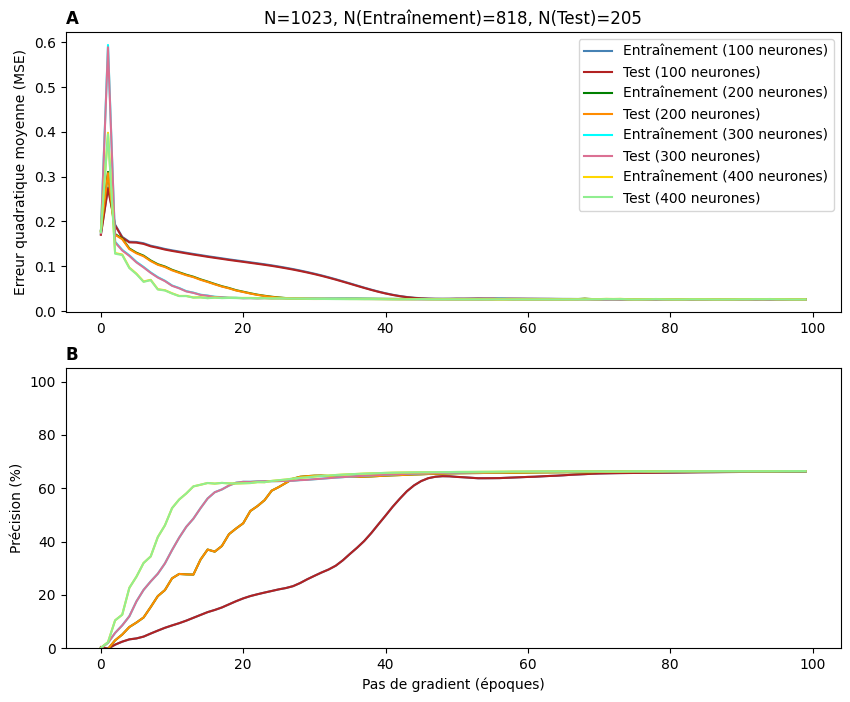

In [34]:
# Visualisation des courbes d'apprentissage
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["100 neurones", "200 neurones", "300 neurones", "400 neurones"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(4, colors, info_exp, 
                              title,
                              tests_couche_interne)

# Les couches internes 

In [35]:
tests_couche_interne = []

for i in range(5,8) :
    ae_ci, en_ci = buildModel(insize, outsize, i*100, 2)
    trainMSE_ci, testMSE_ci, trainCorr_ci, testCorr_ci = trainModel(ae_ci, X_train, X_test, 100, 0.001)
    tests_couche_interne.append([trainMSE_ci, testMSE_ci, [i * 100 for i in trainCorr_ci], [i * 100 for i in trainCorr_ci]])

Epoch 0 --- Train Error : 0.17 ~ Test Error : 0.17 ~ Train Acc : -0.0 ~ Test Acc : -0.0 
Epoch 10 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.58 ~ Test Acc : 0.58 
Epoch 20 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.62 ~ Test Acc : 0.62 
Epoch 30 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.65 
Epoch 40 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 70 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 80 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 90 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 0 --- Train Error : 0.18 ~ Test Error : 0.18 ~ Train Acc : 0.01 ~ Test Acc : 0.01 
Epoch 10 ---

In [28]:
print(tests_couche_interne)


[[[0.17532366514205933, 0.17918916046619415, 0.16999569535255432, 0.16602343320846558, 0.16469132900238037, 0.15459568798542023, 0.1560569405555725, 0.14654669165611267, 0.14398492872714996, 0.1401444971561432, 0.13584241271018982, 0.13338370621204376, 0.13016843795776367, 0.12688621878623962, 0.12409140169620514, 0.12152677774429321, 0.11881415545940399, 0.11621186137199402, 0.11386150866746902, 0.11142546683549881, 0.1090903952717781, 0.10679539293050766, 0.10447505861520767, 0.10214788466691971, 0.09971516579389572, 0.09717004746198654, 0.09442125260829926, 0.09125349670648575, 0.08768787235021591, 0.08352091163396835, 0.07847218215465546, 0.07296683639287949, 0.06735970824956894, 0.06126908212900162, 0.05534002184867859, 0.049627114087343216, 0.044166140258312225, 0.039500799030065536, 0.035524170845746994, 0.032314274460077286, 0.029983751475811005, 0.02838812954723835, 0.02742171473801136, 0.02699548378586769, 0.02692713588476181, 0.027053600177168846, 0.027338987216353416, 0.027

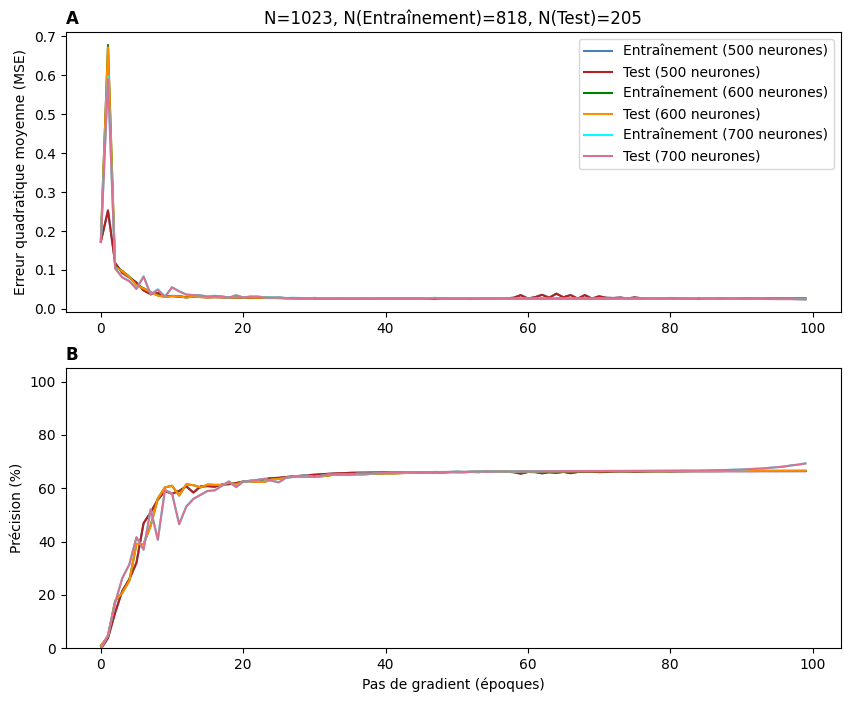

In [46]:
info_exp = ["500 neurones", "600 neurones", "700 neurones", "800 neurones"]
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_couche_interne)

In [2]:
# La taille de 400 neurones en couche interne est conservée pour le futur.
# Après 400 neurones, les courbes sont semblabes et deviennent moins lisses.

In [29]:
# Variation dans la régularisation L2 (wd, weight decay)
tests_wd = []
wd_trys = [0.0001, 0.001, 0.01, 0.1]
for wd in wd_trys: 
    ae_wd, en_wd = buildModel(insize, outsize, 400, 2)
    trainMSE_wd, testMSE_wd, trainCorr_wd, testCorr_wd = trainModel(ae_wd, X_train, X_test, 100, 0.001, wd)
    tests_wd.append([trainMSE_wd, testMSE_wd, [i*100 for i in trainCorr_wd], [1*100 for i in trainCorr_wd]])

Epoch 0 --- Train Error : 0.18 ~ Test Error : 0.18 ~ Train Acc : -0.01 ~ Test Acc : -0.01 
Epoch 10 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.56 ~ Test Acc : 0.56 
Epoch 20 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.57 ~ Test Acc : 0.57 
Epoch 30 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.64 ~ Test Acc : 0.63 
Epoch 40 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.64 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.65 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 70 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.67 ~ Test Acc : 0.67 
Epoch 80 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.69 ~ Test Acc : 0.68 
Epoch 90 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.7 ~ Test Acc : 0.69 
Epoch 0 --- Train Error : 0.17 ~ Test Error : 0.18 ~ Train Acc : -0.0 ~ Test Acc : -0.0 
Epoch 10 --

[[[0.1713298261165619, 0.41941899061203003, 0.1317639797925949, 0.12395554035902023, 0.10184125602245331, 0.0875566303730011, 0.07691776007413864, 0.06070909649133682, 0.05975482612848282, 0.046652186661958694, 0.041124530136585236, 0.03893299028277397, 0.0322827510535717, 0.03230397030711174, 0.029888130724430084, 0.02965240739285946, 0.02959434874355793, 0.02836652286350727, 0.029428759589791298, 0.028591368347406387, 0.029226966202259064, 0.028720827773213387, 0.028798870742321014, 0.02855287306010723, 0.028274282813072205, 0.02819238044321537, 0.027830520644783974, 0.027658933773636818, 0.027369758114218712, 0.027258742600679398, 0.027089539915323257, 0.026876991614699364, 0.026764266192913055, 0.026667069643735886, 0.026561114937067032, 0.026434512808918953, 0.02636476419866085, 0.026263458654284477, 0.026208622381091118, 0.02616172656416893, 0.026195542886853218, 0.02620304748415947, 0.026444053277373314, 0.026088617742061615, 0.025975501164793968, 0.02601936273276806, 0.02602862

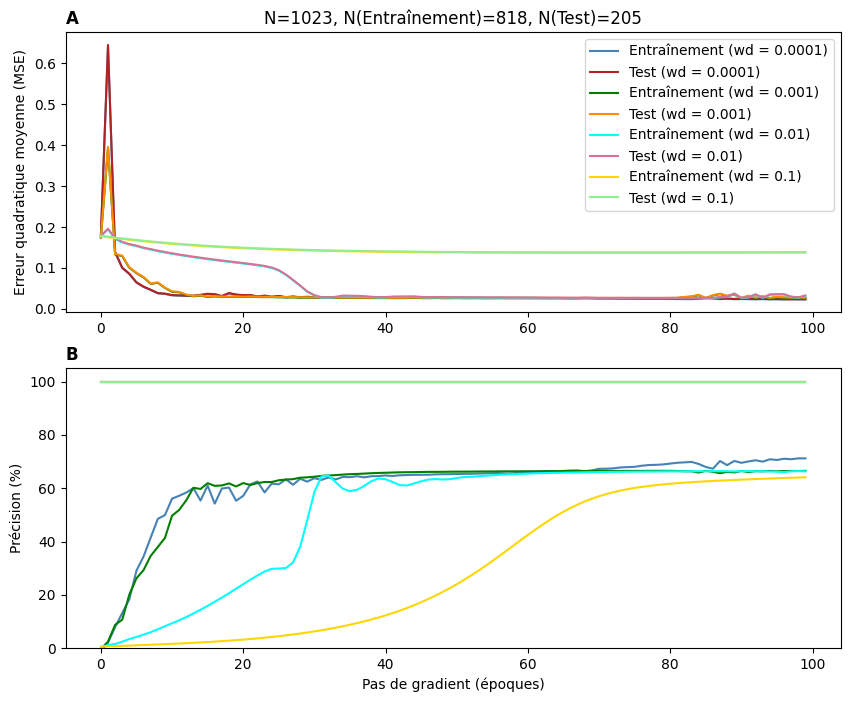

In [30]:
# Visualisation des courbes d'apprentissage
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["wd = 0.0001", "wd = 0.001", "wd = 0.01", "wd = 0.1"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(4, colors, info_exp, 
                              title,
                              tests_wd)

Auto-encodeur variationnel (VAE)

#### B. <u>Expérience sur la variation de la taille de l'espace latent dans le cas d'un AE ou VAE.</u>

Tailles testées : [1,2,3,5,10,15,20,25,30,50,75,100,125,150,200,300]

Quels sont les paramètres idéaux? Quelle est la taille de bottleneck idéale? Quels sont les paramètres sensibles? Qu'en concluez-vous?